In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
import fitsio
# To activate logging
setup_logging()

In [8]:
d = fitsio.read('/pscratch/sd/a/arosado/lognormal_mocks/data_3.0_1250.0_1024_8000.0_3.0_1_cubic.fits')

In [2]:
r = fitsio.read('/pscratch/sd/a/arosado/lognormal_mocks/randoms_3.0_1250.0_1024_8000.0_3.0_1_cubic.fits')

In [9]:
r['Position'][:,0].size / d['Position'][:,0].size

3.9997080811755517

In [2]:
data = fitsio.read('/pscratch/sd/a/arosado/lognormal_mocks/cutsky/test3/data_cutsky_3.0_1250.0_1024_8000.0_3.0_1.fits')
randoms  = fitsio.read('/pscratch/sd/a/arosado/lognormal_mocks/cutsky/test3/randoms_cutsky_3.0_1250.0_1024_8000.0_3.0_1.fits')

In [12]:
randoms['RA'].size / data['RA'].size

0.6880322228357755

In [5]:
boxsize = 8000
nmesh = 512

In [6]:
edges={'min':0,'step':0.001}

data_pos = [data['RA'], data['DEC'], data['Distance']]
data_w = np.ones(data['RA'].size)

rands_pos = [randoms['RA'], randoms['DEC'], randoms['Distance']]
rands_w = np.ones(randoms['RA'].size)

# pass mpiroot=0 if input positions and weights are not MPI-scattered
result = CatalogFFTPower(data_positions1=data_pos,  data_weights1=data_w, randoms_positions1=rands_pos, randoms_weights1=rands_w,
                         edges=edges, ells=(0,2,4), boxsize=boxsize, nmesh=nmesh, resampler='tsc', 
                         interlacing=2, los=None, position_type='rdd')

[000023.91]  04-14 14:32  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[512 512 512], boxsize=[8000. 8000. 8000.], boxcenter=[-1493.8398686  -2072.36304128  1739.02750665], dtype=float64).
[000024.18]  04-14 14:32  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 9183301.
[000025.22]  04-14 14:32  CatalogMesh                  INFO     Painted 4194304 out of 9183301 objects to mesh.
[000025.22]  04-14 14:32  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 9183301.
[000026.32]  04-14 14:32  CatalogMesh                  INFO     Painted 8388608 out of 9183301 objects to mesh.
[000026.32]  04-14 14:32  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 9183301.
[000026.55]  04-14 14:32  CatalogMesh                  INFO     Painted 9183301 out of 9183301 objects to mesh.
[000026.62]  04-14 14:32  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 6318407.
[000027.93]  04-14 14:32  CatalogMesh                  I

Shot noise is 3816.6689.
Normalization is 5903.1835.


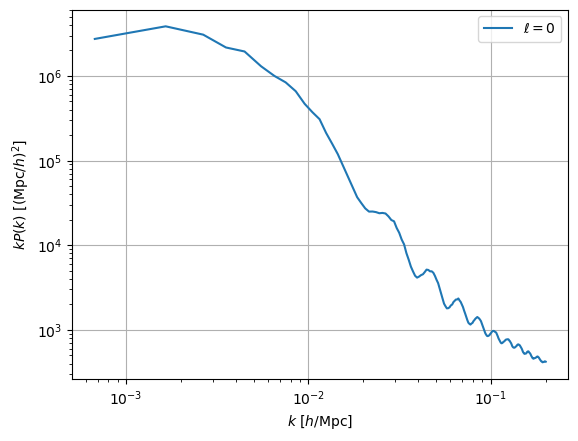

In [8]:
ax = plt.gca()
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ell=0
k,pk = poles(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

[000318.70]  04-14 14:36  CatalogFFTPower              INFO     Loading /pscratch/sd/a/arosado/lognormal_mocks/power_1250.0_512_cubic.npy.
Shot noise is 1922.2619.
Normalization is 216914.7868.


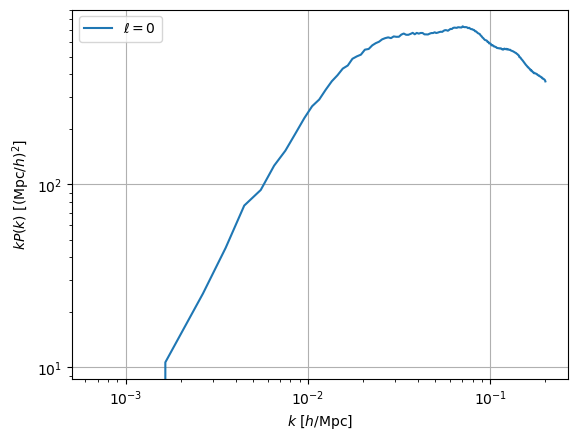

In [11]:
nmesh = 512
#fn = os.path.join(cutsky_dir, f'power_{nmesh}_cutsky.npy')
fn = '/pscratch/sd/a/arosado/lognormal_mocks/power_1250.0_512_cubic.npy'
result_cubic = CatalogFFTPower.load(fn)

ax = plt.gca()
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ell=0
k,pk = poles(ell=ell, return_k=True, complex=False)
ax.plot(k, k*pk, label=f'$\ell = {ell}$')
ax.legend()
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

In [6]:
r_fn = '/pscratch/sd/a/arosado/lognormal_mocks/randoms_3.0_1250.0_1024_8000.0_3.00_1_full.fits'
r = fitsio.read(r_fn, rows=[1])

In [ ]:
# cutsky region with no pattern
rarange = [opt.ramin,opt.ramax]
decrange = [opt.decmin, opt.decmax]
data_cutsky = data.cutsky(drange=drange, rarange=rarange, decrange=decrange)
randoms_cutsky = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)

#-----------------------------------------------------
distance_to_redshift = DistanceToRedshift(distance=cosmo.comoving_radial_distance)
for catalog in [data_cutsky, randoms_cutsky]:
    catalog['Distance'], catalog['RA'], catalog['DEC'] = utils.cartesian_to_sky(catalog.position)
    catalog['Z'] = distance_to_redshift(catalog['Distance'])

#-----------------------------------------------------
# save catalogs to .fits
file_id = f"{bias}_{nb_deg}_{nmesh}_{boxsize}_{zeff}"
data_fn = os.path.join(cutsky_dir, 'data_cutsky_'+file_id+'_cutsky.fits')
data_cutsky.write(data_fn)

rands_fn = os.path.join(cutsky_dir, 'randoms_cutsky_'+file_id+'_cutsky.fits')
randoms_cutsky.write(rands_fn)


In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0,0), seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o,b in zip(offset,boxsize)]
        weights = rng.uniform(0.5, 1., size)
        toret.append((positions, weights))
    return toret

In [4]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

In [5]:
# Compute the cross-power spectrum multipoles of order (0, 2, 4), with 10 bins between 0 and 0.2
# using local line-of-sight, box physical size of 2000, mesh size of 256^3, TSC assignment scheme,
# interlacing correction (2nd order)
# los can be None (local) or any box axis ('x', 'y', 'z') or 3-vector
# Input positions, weights are gathered (not MPI-scattered), so we tell CatalogFFTPower
# to take positions and weights from rank 0 (mpiroot = 0)
# position_type is 'xyz' because input positions are (3, N); in case positions are (N, 3), pass position_type='pos'
# weights can be ommitted if constant (1)
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         data_positions2=data_positions2, data_weights2=data_weights2,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz', mpiroot=0)
# Note that you can also provide single data/randoms catalogs (auto-correlation),
# no randoms (uniform selection function), no weights (assumed unity)

[000106.59]  04-14 11:13  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   499.99200437  499.99818966], dtype=float64).
[000106.62]  04-14 11:13  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000106.68]  04-14 11:13  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000106.68]  04-14 11:13  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000106.73]  04-14 11:13  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000106.74]  04-14 11:13  CatalogMesh                  INFO     Running interlacing at order 2.
[000106.75]  04-14 11:13  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000106.80]  04-14 11:13  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000106.80]  04-14 11:13  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

Shot noise is 0.0000.
Normalization is 0.0553.


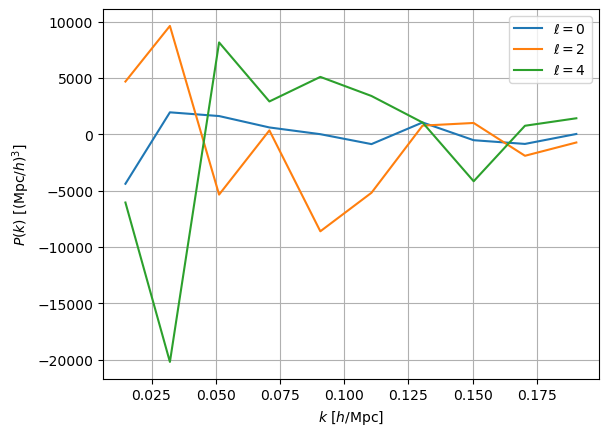

In [6]:
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    # Calling poles() removes shotnoise for ell == 0 by default;
    # Pass remove_shotnoise = False if you do not want to;
    # See get_power() for all arguments
    ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected